## `Introduction`

I decided to write this kernel because **Titanic: Machine Learning from Disaster** is one of my favorite competitions on Kaggle. This is a beginner level kernel which focuses on **Exploratory Data Analysis** and **Feature Engineering**. A lot of people start Kaggle with this competition and they get lost in extremely long tutorial kernels. This is a short kernel compared to the other ones. I hope this will be a good guide for starters and inspire them with new feature engineering ideas.

**Titanic: Machine Learning from Disaster** is a great competition to apply domain knowledge for feature engineering, so I made a research and learned a lot about Titanic. There are many secrets to be revealed beneath the Titanic dataset. I tried to find out some of those secret factors that had affected the survival of passengers when the Titanic was sinking. I believe there are other features still waiting to be discovered. 

This kernel has **2** main sections; **Exploratory Data Analysis**, **Feature Engineering** , and it can achieve top **2%** (**0.83732**) public leaderboard score with a tuned Random Forest Classifier. It takes 60 seconds to run whole notebook. If you have any idea that might improve this kernel, please be sure to comment, or fork and experiment as you like. If you didn't understand any part, feel free to ask.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df = pd.read_csv(r'C:\Users\Kunwa\OneDrive\Desktop\Data Science\Data Science Course Project\Data\titanic.csv')

## **1. Exploratory Data Analysis**

### **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [3]:
df.head()

PassengerId  Survived  Pclass   
0            1         0       3  \
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp   
0                            Braund, Mr. Owen Harris    male  22.0      1  \
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
df.drop(columns= 'PassengerId' , inplace = True)

In [5]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### **1.2 Missing Values**
As seen from below, some columns have missing values. 

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

- **Age** have 177 null values 
- **Cabin** have 687 null values
- **Embarked** have 2 null values

#### **1.2.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

- **.rest_index()** gives index and level_0,level_1,0

In [7]:
df_all_corr = df.corr(numeric_only = True).abs().unstack().sort_values(ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

Feature 1 Feature 2  Correlation Coefficient
4        Age       Age                 1.000000
10       Age    Pclass                 0.369226
15       Age     SibSp                 0.308247
20       Age     Parch                 0.189119
24       Age      Fare                 0.096067
31       Age  Survived                 0.077221

In order to be more accurate, `Sex` feature is used as the second level of `groupby` while filling the missing `Age` values. As seen from below, `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` than males. The median ages below are used for filling the missing values in `Age` feature.

In [8]:
age_by_pclass_sex = df['Age'].groupby([df['Sex'],df['Pclass']]).median()
age_by_pclass_sex
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df['Age'].median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [9]:
df.groupby(['Sex','Pclass'])['Age'].median()

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [10]:
age_by_pclass_sex = df['Age'].groupby([df['Sex'],df['Pclass']]).median()
age_by_pclass_sex

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        df['Age'].fillna(age_by_pclass_sex[sex][pclass],inplace=True)


df.Age.isnull().sum()

0

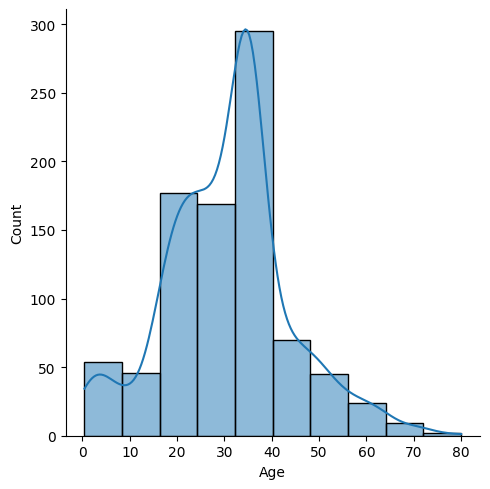

In [11]:
sns.displot(x = 'Age', data = df, bins = 10, kde = True)

#### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [12]:
df[df['Embarked'].isnull()]

Survived  Pclass                                       Name     Sex   
61          1       1                        Icard, Miss. Amelie  female  \
829         1       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   38.0      0      0  113572  80.0   B28      NaN  
829  62.0      0      0  113572  80.0   B28      NaN

When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

Missing values in `Embarked` are filled with **S** with this information.

In [13]:
df['Embarked'] = df['Embarked'].fillna('S')

<Axes: xlabel='Embarked', ylabel='count'>

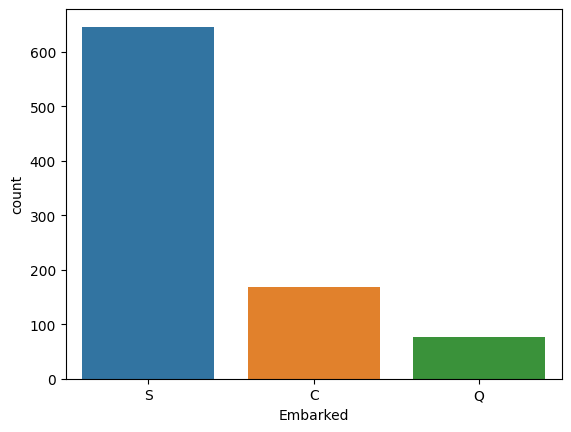

In [14]:
sns.countplot(x = 'Embarked', data = df)

#### **1.2.4 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

In [15]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df['Deck'].sample(4)

285    M
169    M
63     M
0      M
Name: Deck, dtype: object

In [16]:
df_all_decks = df.groupby(['Deck', 'Pclass']).count()
df_all_decks

Survived  Name  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin   
Deck Pclass                                                                
A    1             15    15   15   15     15     15      15    15     15  \
B    1             47    47   47   47     47     47      47    47     47   
C    1             59    59   59   59     59     59      59    59     59   
D    1             29    29   29   29     29     29      29    29     29   
     2              4     4    4    4      4      4       4     4      4   
E    1             25    25   25   25     25     25      25    25     25   
     2              4     4    4    4      4      4       4     4      4   
     3              3     3    3    3      3      3       3     3      3   
F    2              8     8    8    8      8      8       8     8      8   
     3              5     5    5    5      5      5       5     5      5   
G    3              4     4    4    4      4      4       4     4      4   
M    1             40    40   40   40     40     40      40    40      0   
     2            168   168  168  168    168    168     168   168      0   
     3            479   479  479  479    479    479     479   479      0   
T    1              1     1    1    1      1      1       1     1      1   

             Embarked  
Deck Pclass            
A    1             15  
B    1             47  
C    1             59  
D    1             29  
     2              4  
E    1             25  
     2              4  
     3              3  
F    2              8  
     3              5  
G    3              4  
M    1             40  
     2            168  
     3            479  
T    1              1

In [17]:
df_all_decks = df.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'Ticket']).rename(columns={'Name': 'Count'}).T
df_all_decks

Deck     A   B   C   D      E        F     G   M            T
Pclass   1   1   1   1  2   1  2  3  2  3  3   1    2    3  1
Count   15  47  59  29  4  25  4  3  8  5  4  40  168  479  1

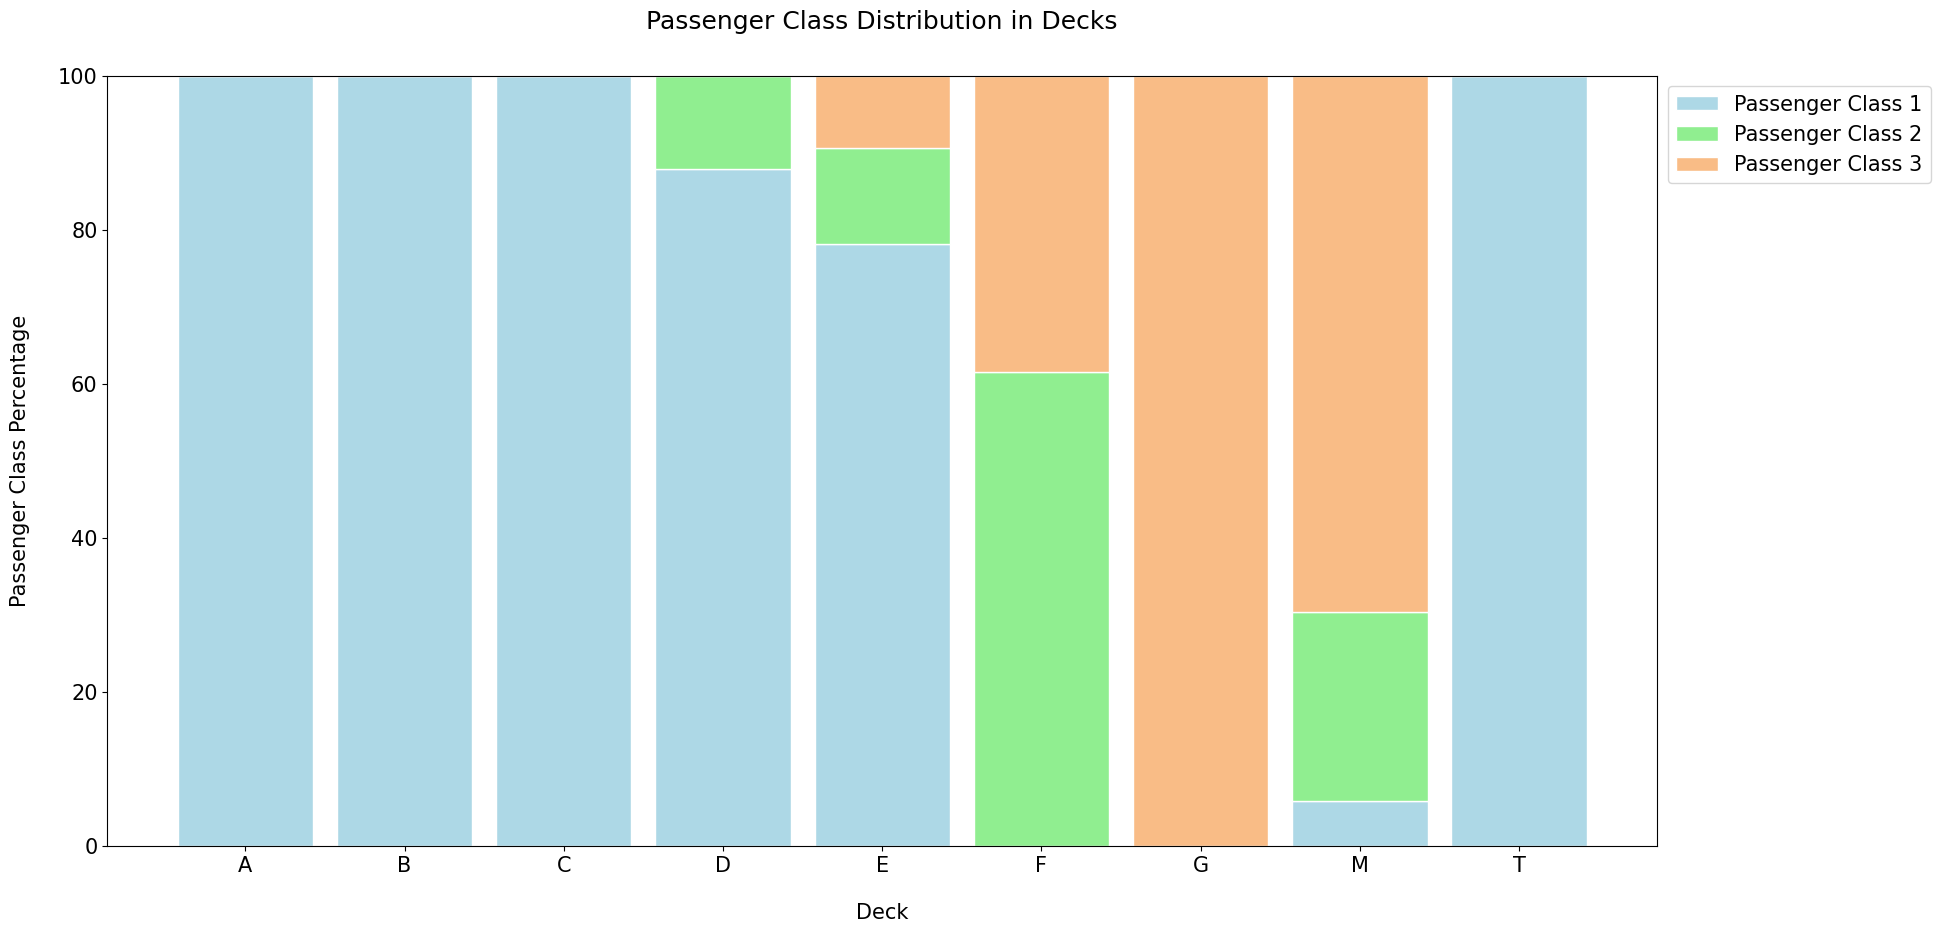

In [18]:
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).T
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='lightblue', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='lightgreen', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [19]:
# Passenger in the T deck is changed to A
idx = df[df['Deck'] == 'T'].index
df.loc[idx, 'Deck'] = 'A'

In [20]:
df.groupby(['Deck', 'Survived']).count()

Pclass  Name  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin   
Deck Survived                                                              
A    0              9     9    9    9      9      9       9     9      9  \
     1              7     7    7    7      7      7       7     7      7   
B    0             12    12   12   12     12     12      12    12     12   
     1             35    35   35   35     35     35      35    35     35   
C    0             24    24   24   24     24     24      24    24     24   
     1             35    35   35   35     35     35      35    35     35   
D    0              8     8    8    8      8      8       8     8      8   
     1             25    25   25   25     25     25      25    25     25   
E    0              8     8    8    8      8      8       8     8      8   
     1             24    24   24   24     24     24      24    24     24   
F    0              5     5    5    5      5      5       5     5      5   
     1              8     8    8    8      8      8       8     8      8   
G    0              2     2    2    2      2      2       2     2      2   
     1              2     2    2    2      2      2       2     2      2   
M    0            481   481  481  481    481    481     481   481      0   
     1            206   206  206  206    206    206     206   206      0   

               Embarked  
Deck Survived            
A    0                9  
     1                7  
B    0               12  
     1               35  
C    0               24  
     1               35  
D    0                8  
     1               25  
E    0                8  
     1               24  
F    0                5  
     1                8  
G    0                2  
     1                2  
M    0              481  
     1              206

In [21]:
df_all_decks_survived = df.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
df_all_decks_survived

Deck      A      B       C      D      E      F     G       M     
Survived  0  1   0   1   0   1  0   1  0   1  0  1  0  1    0    1
Count     9  7  12  35  24  35  8  25  8  24  5  8  2  2  481  206

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M'], dtype='object', name='Deck')


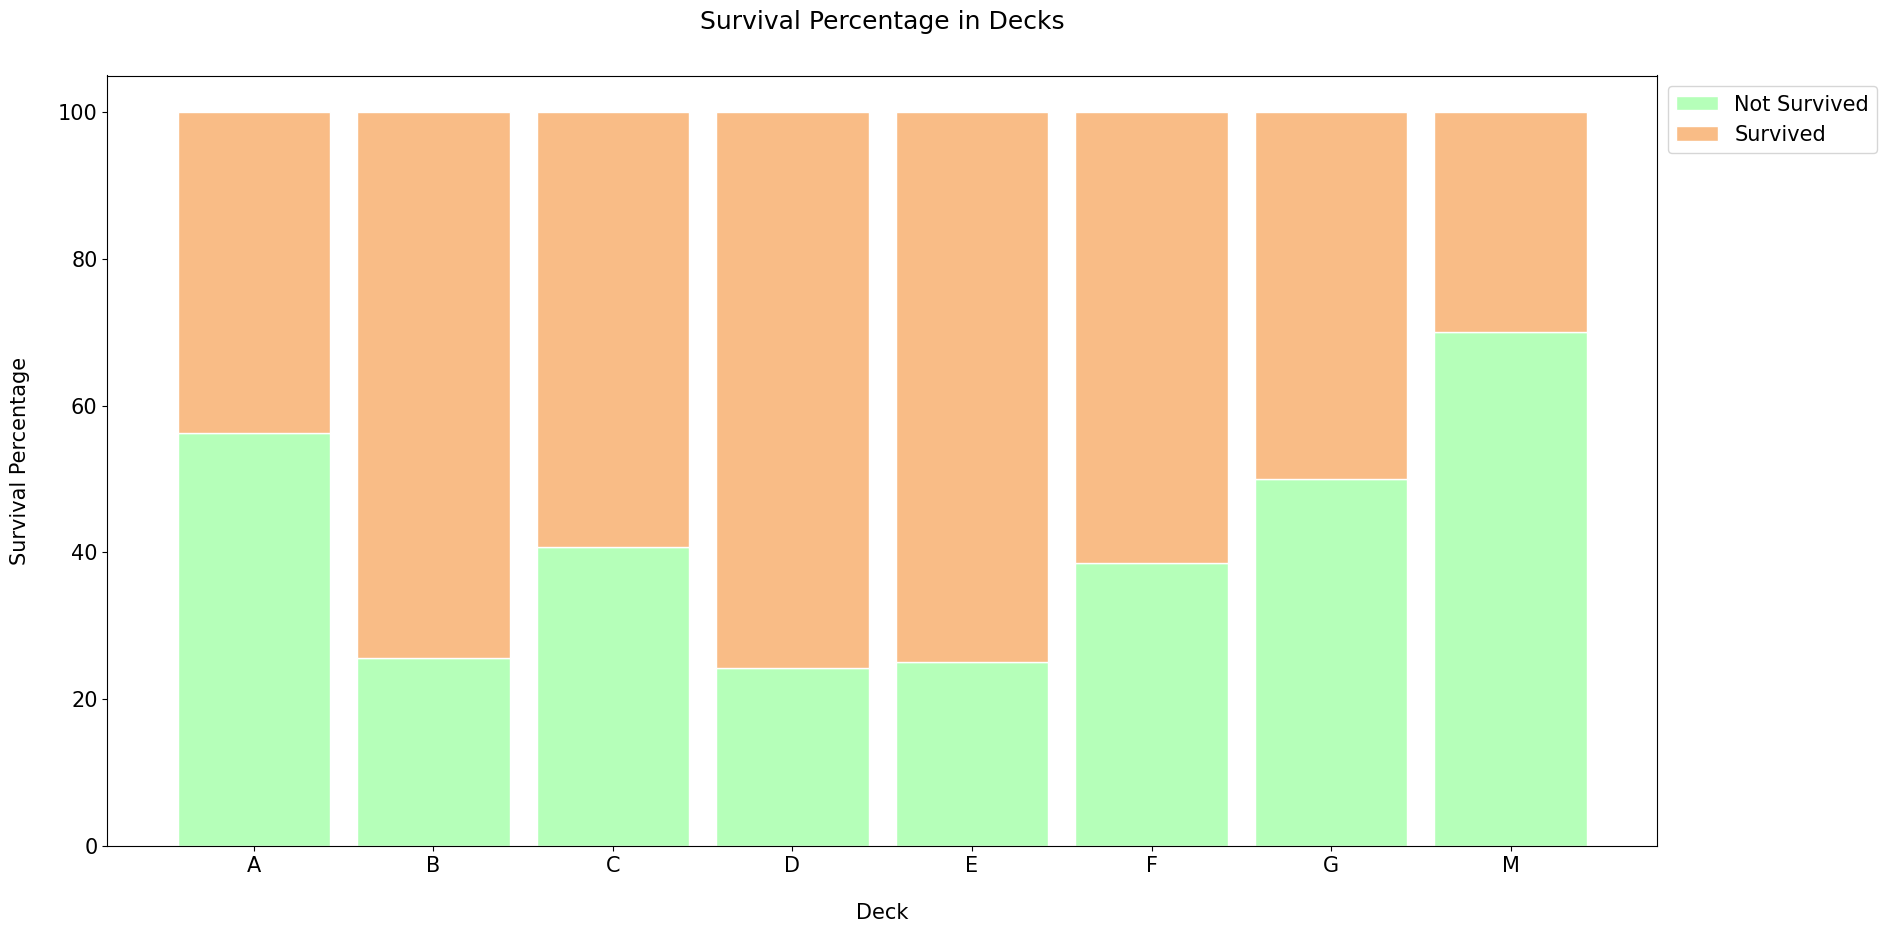

In [22]:

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    
    print(decks)
    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [23]:
df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

df['Deck'].value_counts()

Deck
M      687
ABC    122
DE      65
FG      17
Name: count, dtype: int64

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [24]:
# Dropping the Cabin feature
df.drop(['Cabin'], inplace=True, axis=1)

In [25]:
print('No Null Left')
df.isnull().sum()

No Null Left


Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Deck        0
dtype: int64

### **1.3 Target Distribution**

 `df.shape[0]` is 891 ( total number people )

`df['Survived'].value_counts()`
* **342** (38.38%) of **Survived**
* **549** (61.62%) of **not-Survived**

342 of 891 passengers survived and it is the 38.38% .
549 of 891 passengers didnt survive and it is the 61.62% .


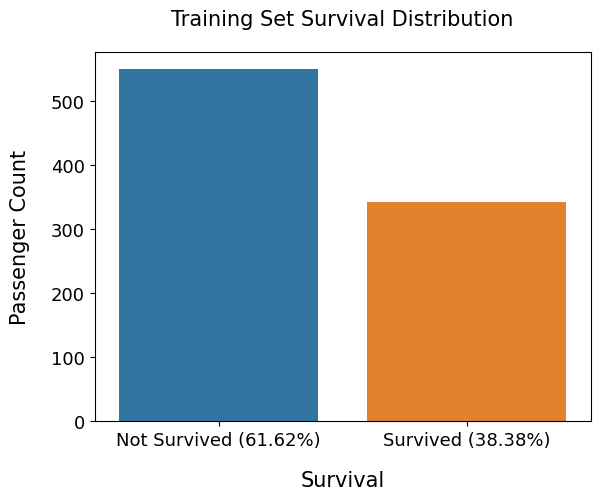

In [26]:
survived = df['Survived'].value_counts()[1]
not_survived = df['Survived'].value_counts()[0]

survived_per = survived / df.shape[0] * 100
not_survived_per = not_survived / df.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% .'.format(survived, df.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% .'.format(not_survived, df.shape[0], not_survived_per))

sns.countplot(x = 'Survived', data = df)

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in  that are higher than **0.1**.

In [27]:
#  high correlations
df_all_corr.drop(df_all_corr.iloc[1::2].index, inplace=True)
df_all_corr = df_all_corr.drop(df_all_corr[df_all_corr['Correlation Coefficient'] == 1.0].index)

In [28]:
corr = df_all_corr['Correlation Coefficient'] > 0.1
df_all_corr[corr]

Feature 1 Feature 2  Correlation Coefficient
6       Fare    Pclass                 0.549500
8      Parch     SibSp                 0.414838
10       Age    Pclass                 0.369226
12  Survived    Pclass                 0.338481
14     SibSp       Age                 0.308247
16      Fare  Survived                 0.257307
18      Fare     Parch                 0.216225
20       Age     Parch                 0.189119
22     SibSp      Fare                 0.159651

<Axes: >

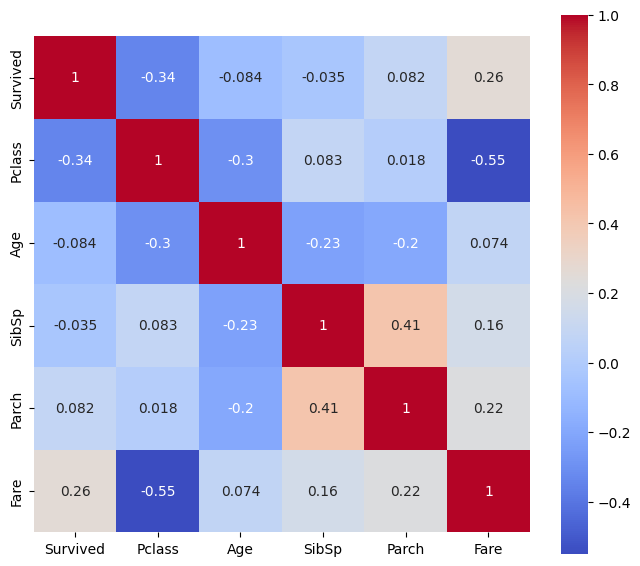

In [29]:
fig = plt.figure(figsize=(8,7))
sns.heatmap(df.corr(numeric_only=True),annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

### **1.5 Target Distribution in Features**

#### **1.5.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

In [30]:
sns.histplot?

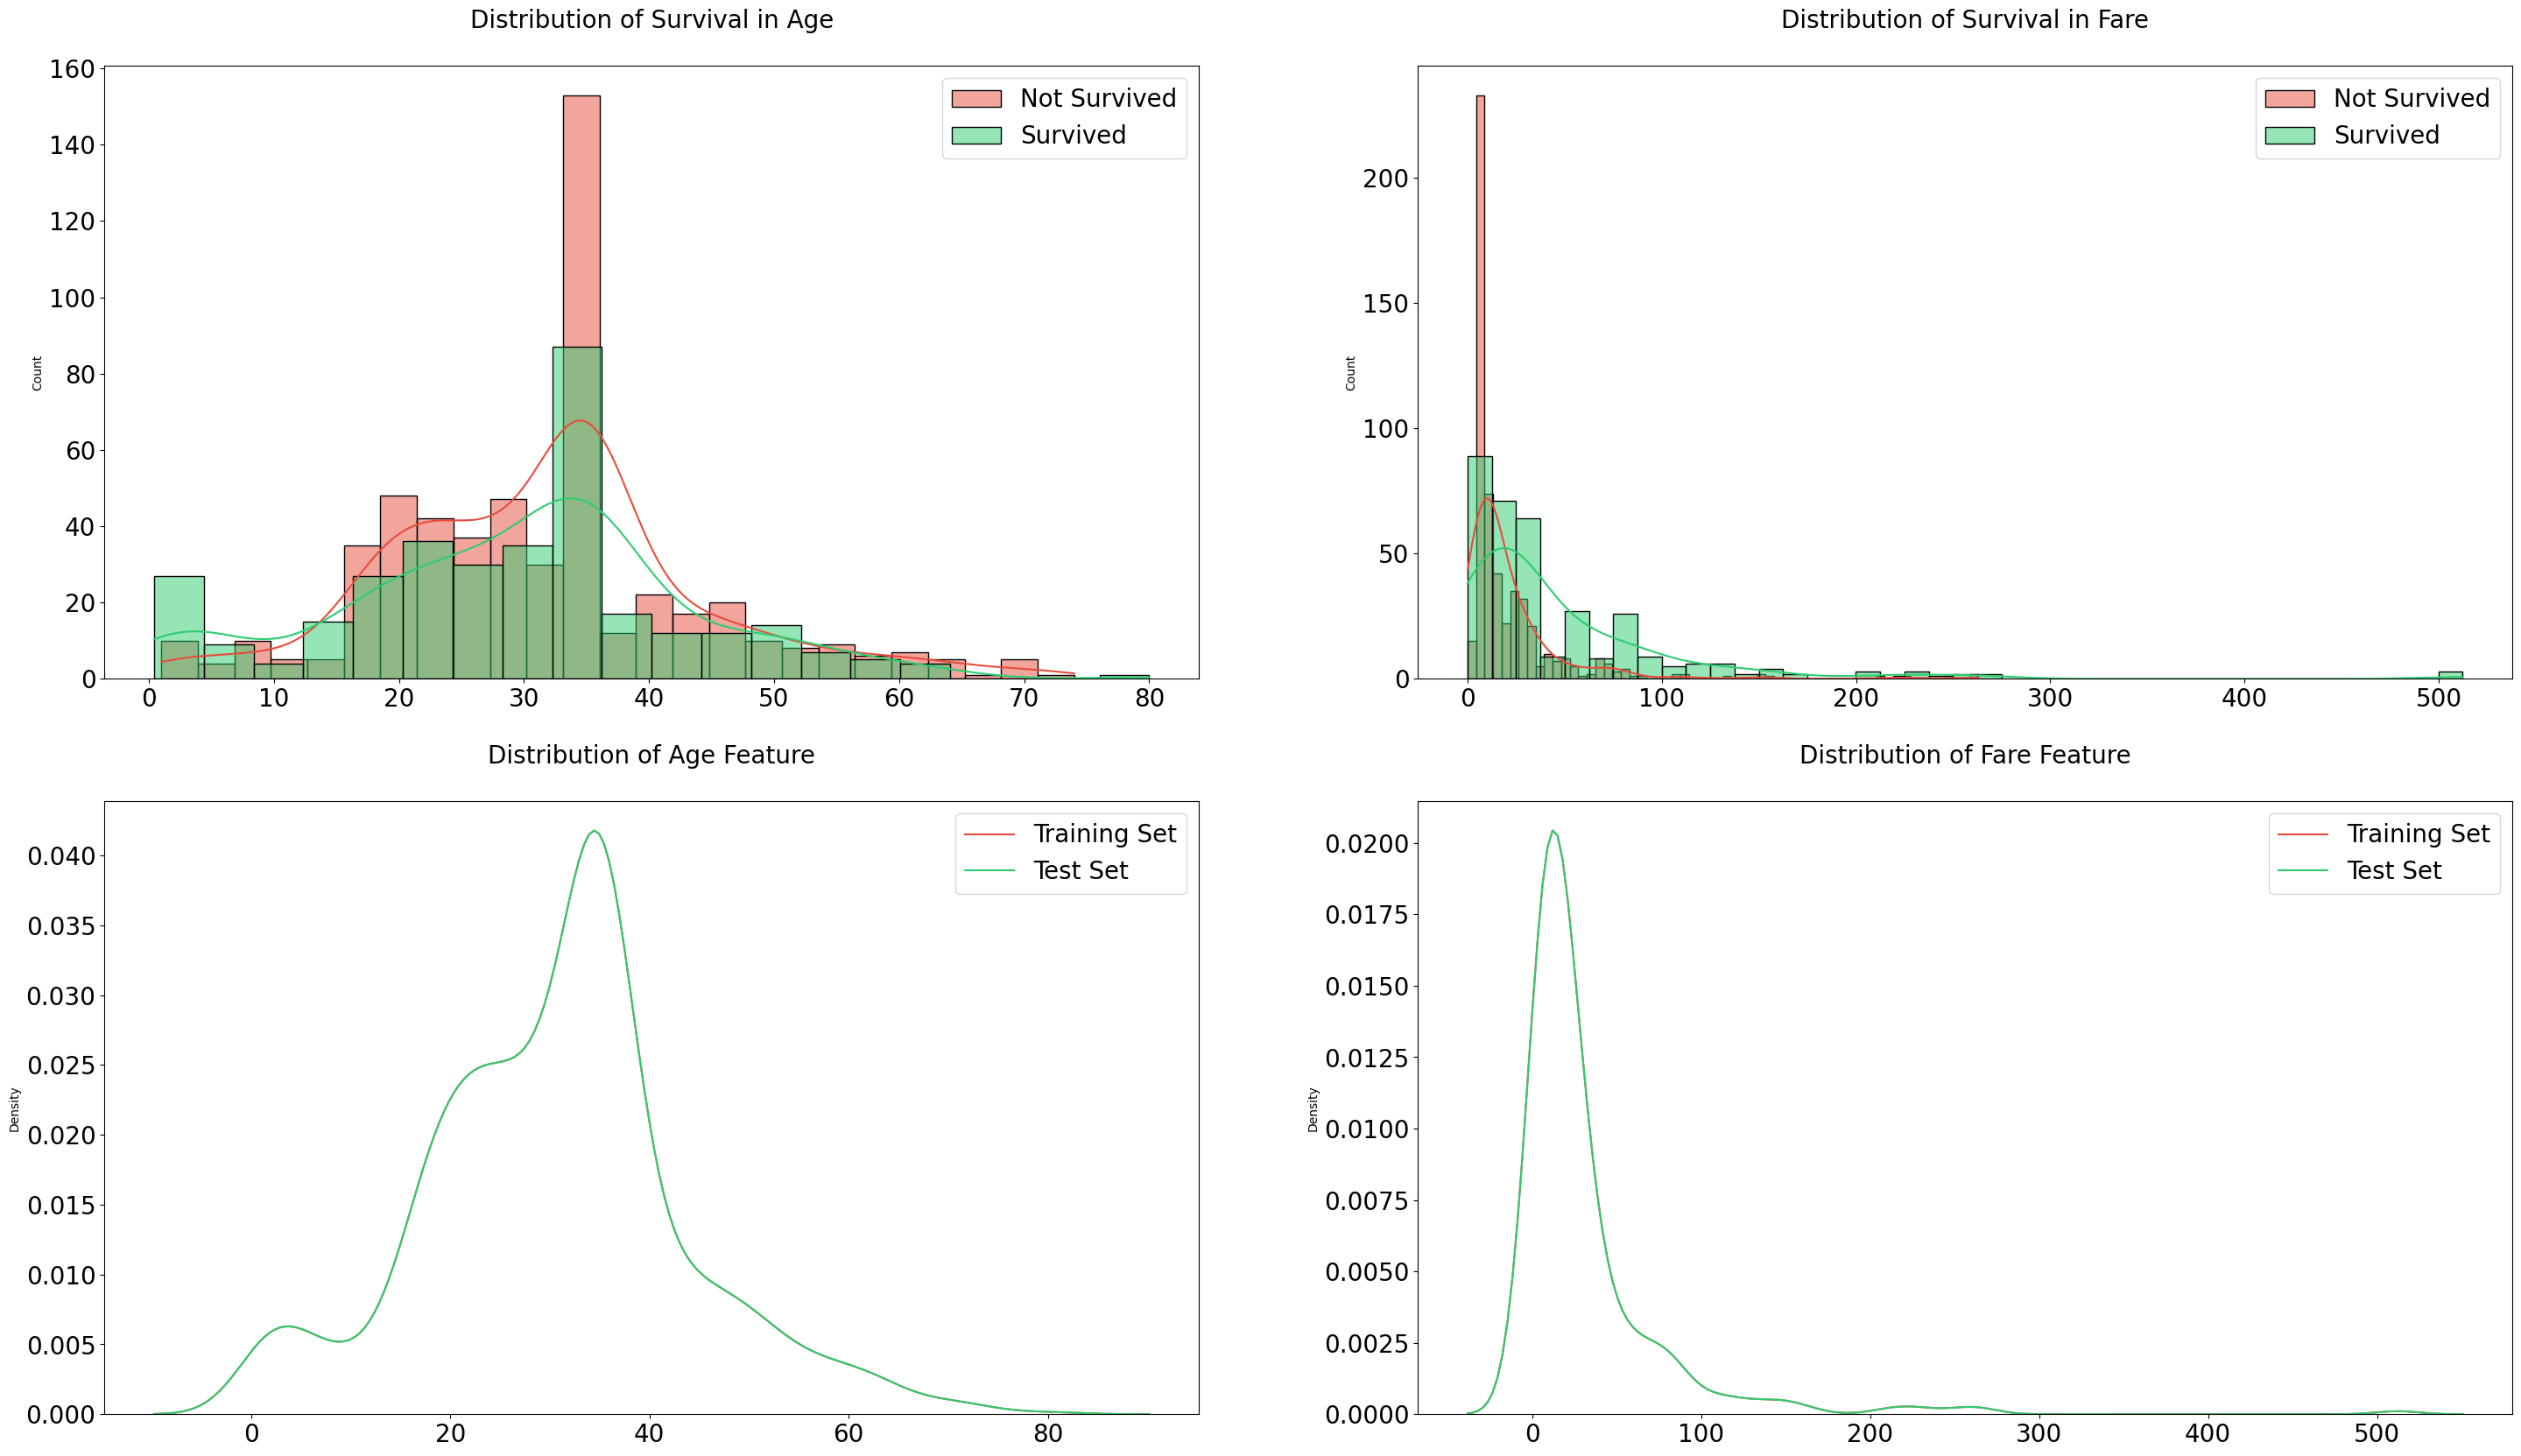

In [31]:
cont_features = ['Age', 'Fare']
surv = df['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.histplot(df[~surv][feature], label='Not Survived',kde =True, color='#e74c3c', ax=axs[0][i])
    sns.histplot(df[surv][feature], label='Survived',kde =True,  color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.kdeplot(df[feature], label='Training Set', color='#e74c3c', ax=axs[1][i])
    sns.kdeplot(df[feature], label='Test Set',  color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

#### **1.5.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.

* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

C:\Users\Kunwa\AppData\Local\Temp\ipykernel_13992\1346015096.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Kunwa\AppData\Local\Temp\ipykernel_13992\1346015096.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Kunwa\AppData\Local\Temp\ipykernel_13992\1346015096.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Kunwa\AppData\Local\Temp\ipykernel_13992\1346015096.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly cal

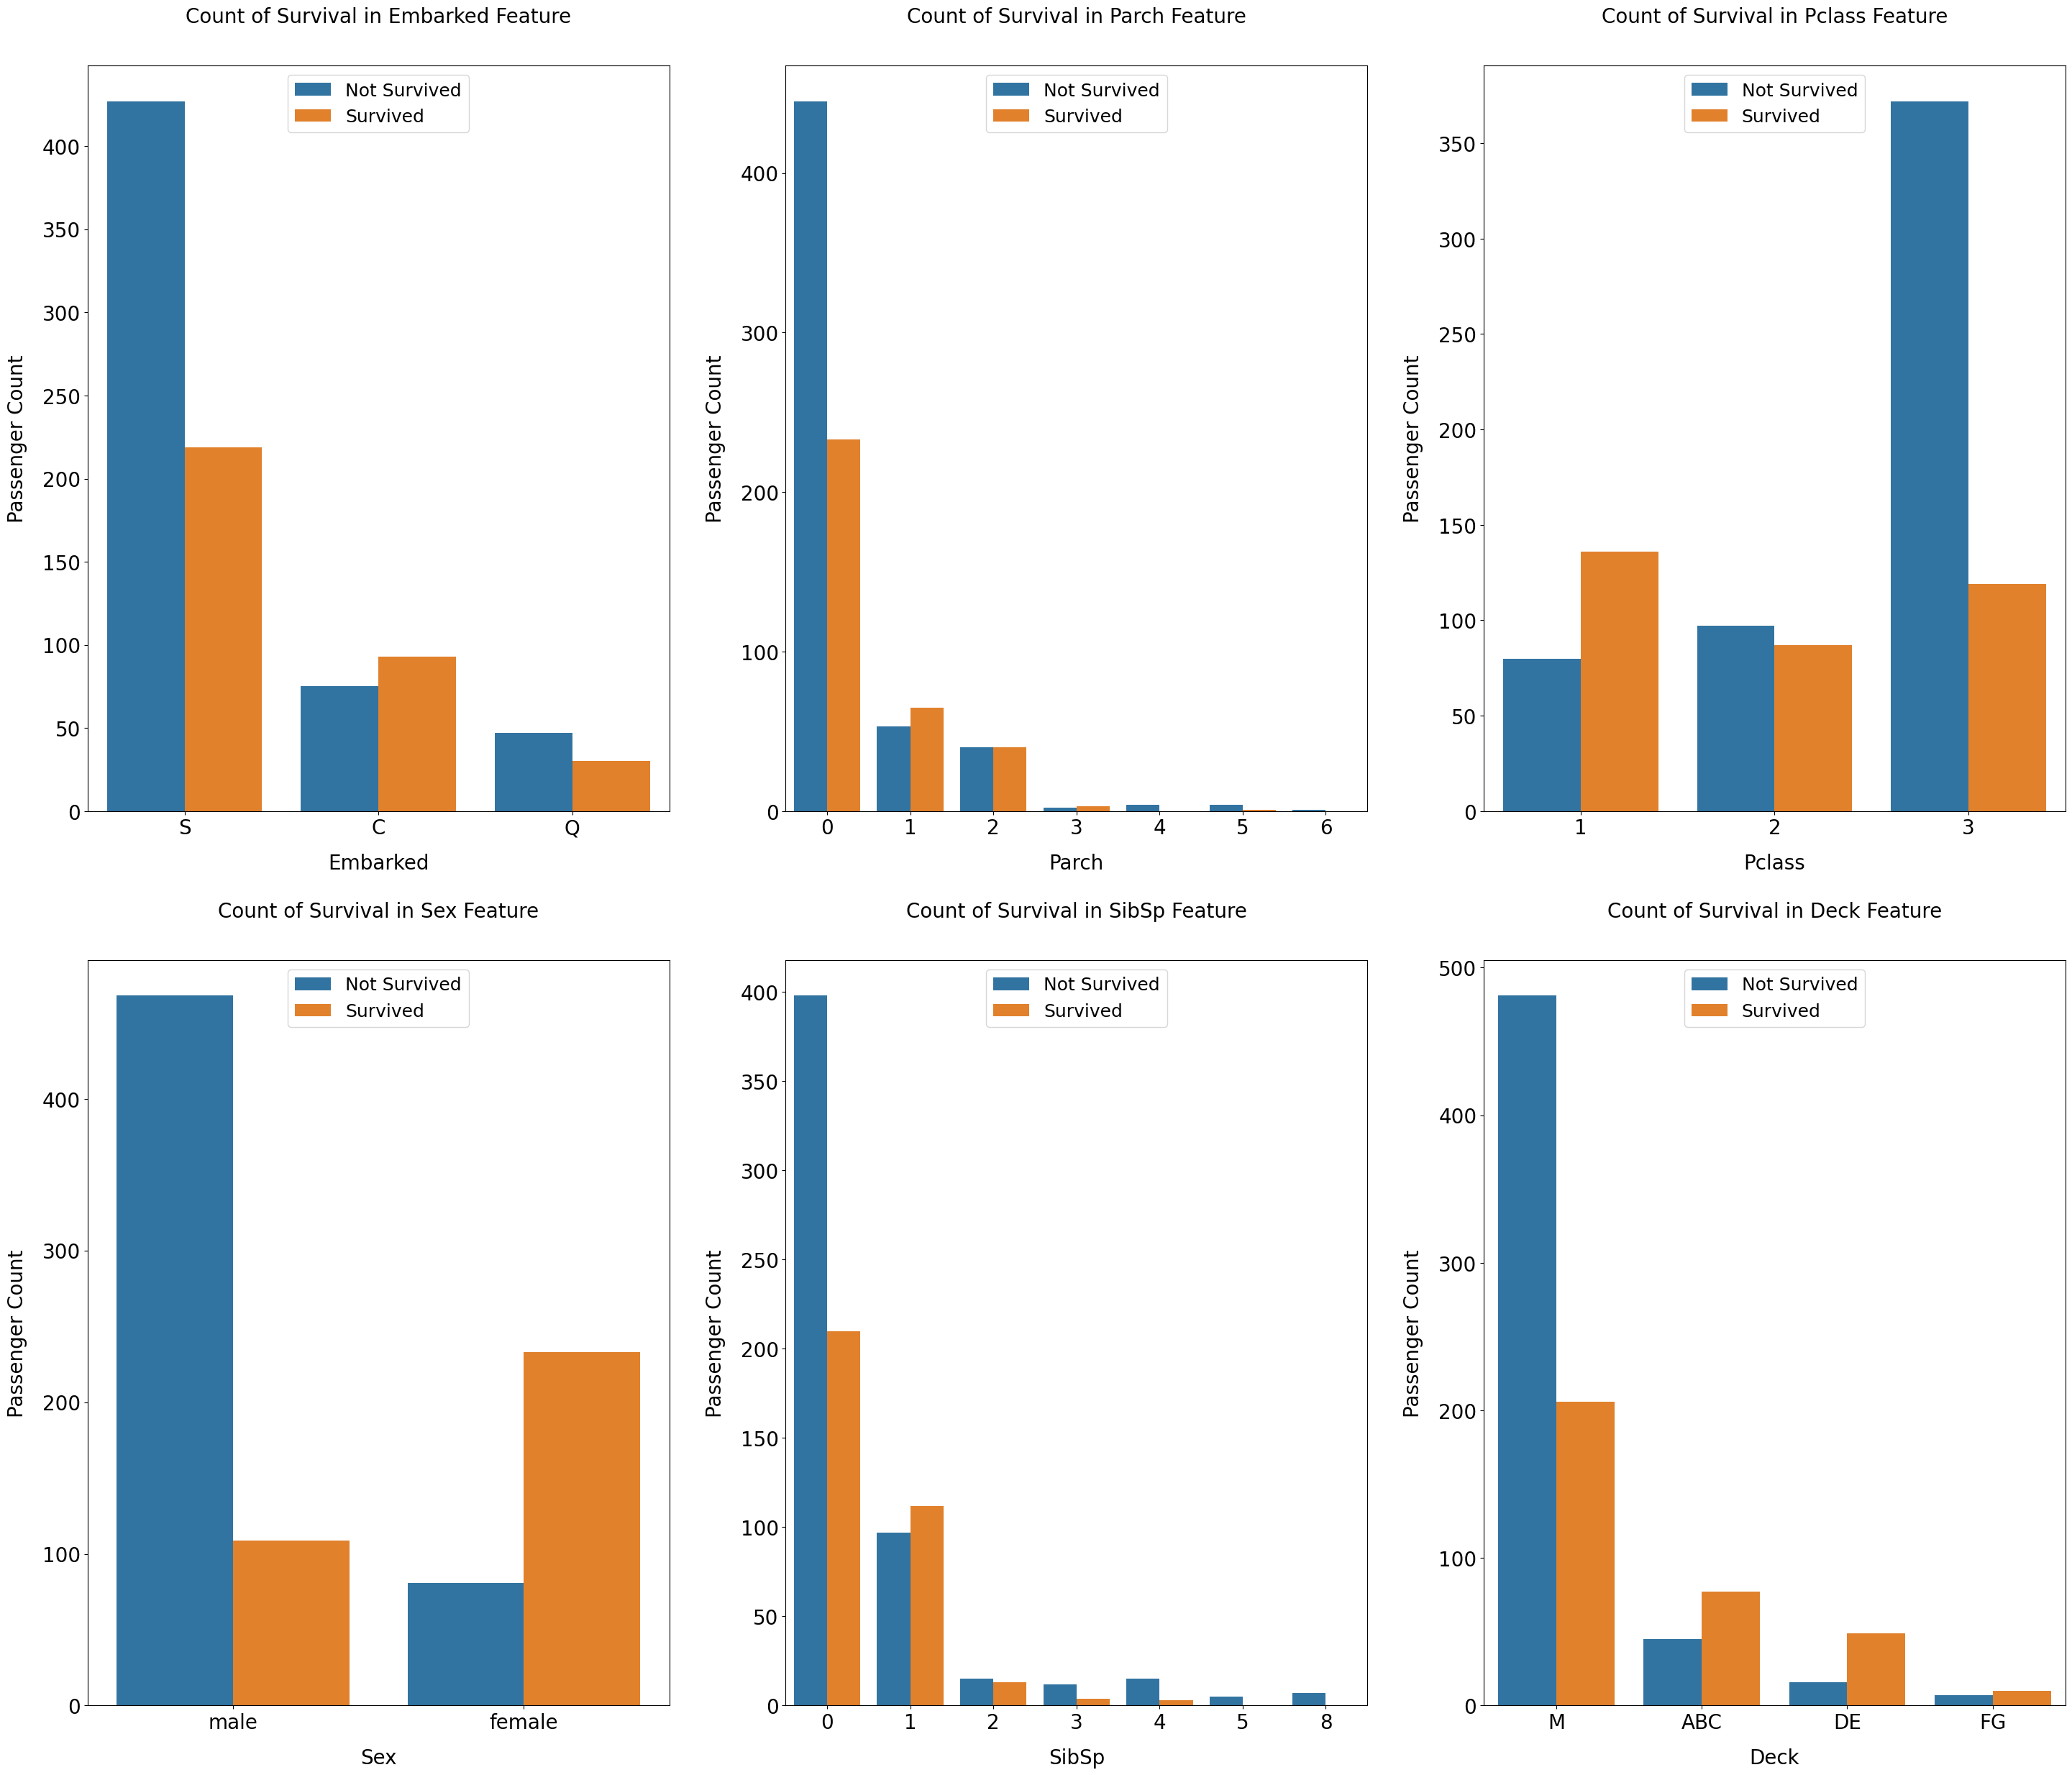

In [32]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)
    

plt.show()

### **1.6 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.

In [33]:
df.head()

Survived  Pclass                                               Name   
0         0       3                            Braund, Mr. Owen Harris  \
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked Deck  
0    male  22.0      1      0         A/5 21171   7.2500        S    M  
1  female  38.0      1      0          PC 17599  71.2833        C  ABC  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S    M  
3  female  35.0      1      0            113803  53.1000        S  ABC  
4    male  35.0      0      0            373450   8.0500        S    M

## **2. Feature Engineering**

### **2m.1 Binning Continuous Features**

#### **2.1.1 Fare**
`Fare` feature is positively skewed and survival rate is extremely high on the right end. **13** quantile based bins are used for `Fare` feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group **(15.742, 23.25]** in the middle with high survival rate that is captured in this process.

In [34]:
df['Fare'] = pd.qcut(df['Fare'], 13)
df['Fare']

0        (7.229, 7.75]
1       (55.9, 83.158]
2        (7.896, 8.05]
3       (33.308, 55.9]
4        (7.896, 8.05]
            ...       
886       (10.5, 13.0]
887    (26.55, 33.308]
888      (15.85, 24.0]
889    (26.55, 33.308]
890      (7.229, 7.75]
Name: Fare, Length: 891, dtype: category
Categories (13, interval[float64, right]): [(-0.001, 7.229] < (7.229, 7.75] < (7.75, 7.896] < (7.896, 8.05] ... (26.55, 33.308] < (33.308, 55.9] < (55.9, 83.158] < (83.158, 512.329]]

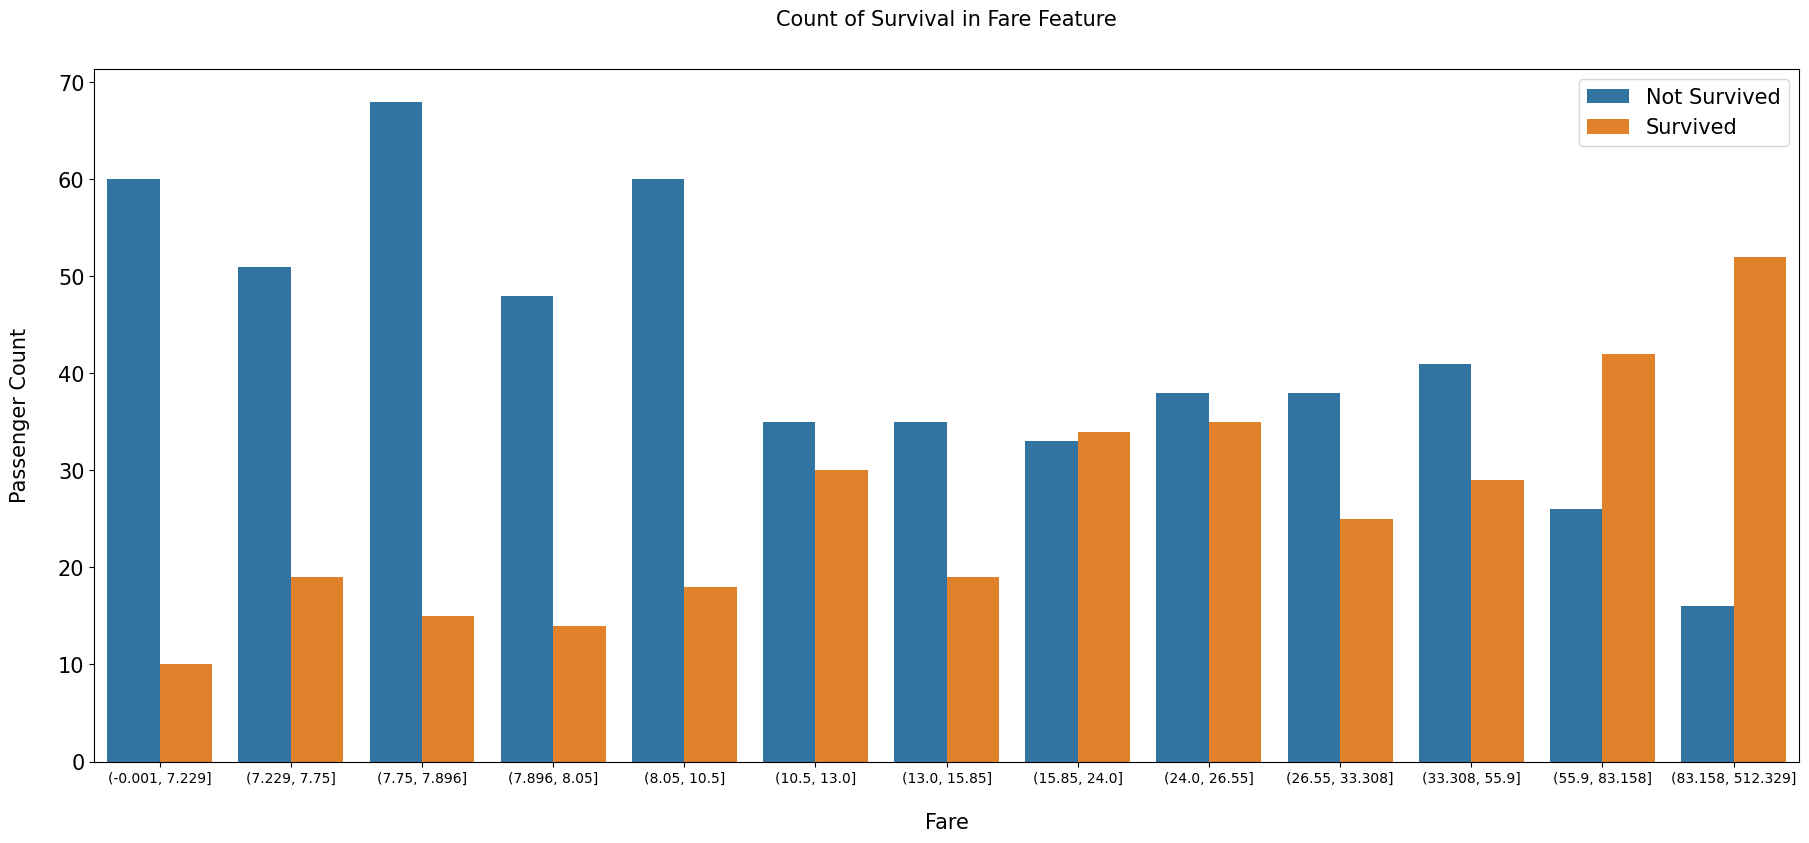

In [35]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

<Axes: xlabel='Survived', ylabel='Age'>

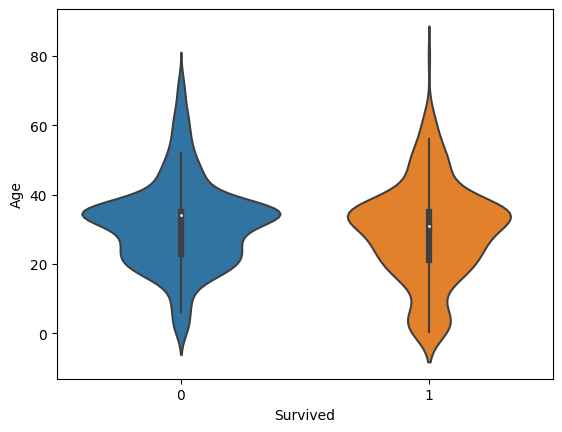

In [36]:
sns.violinplot(x = 'Survived', y = 'Age', data = df)

In [37]:
df['Age'] = pd.qcut(df['Age'], 10,duplicates='drop')

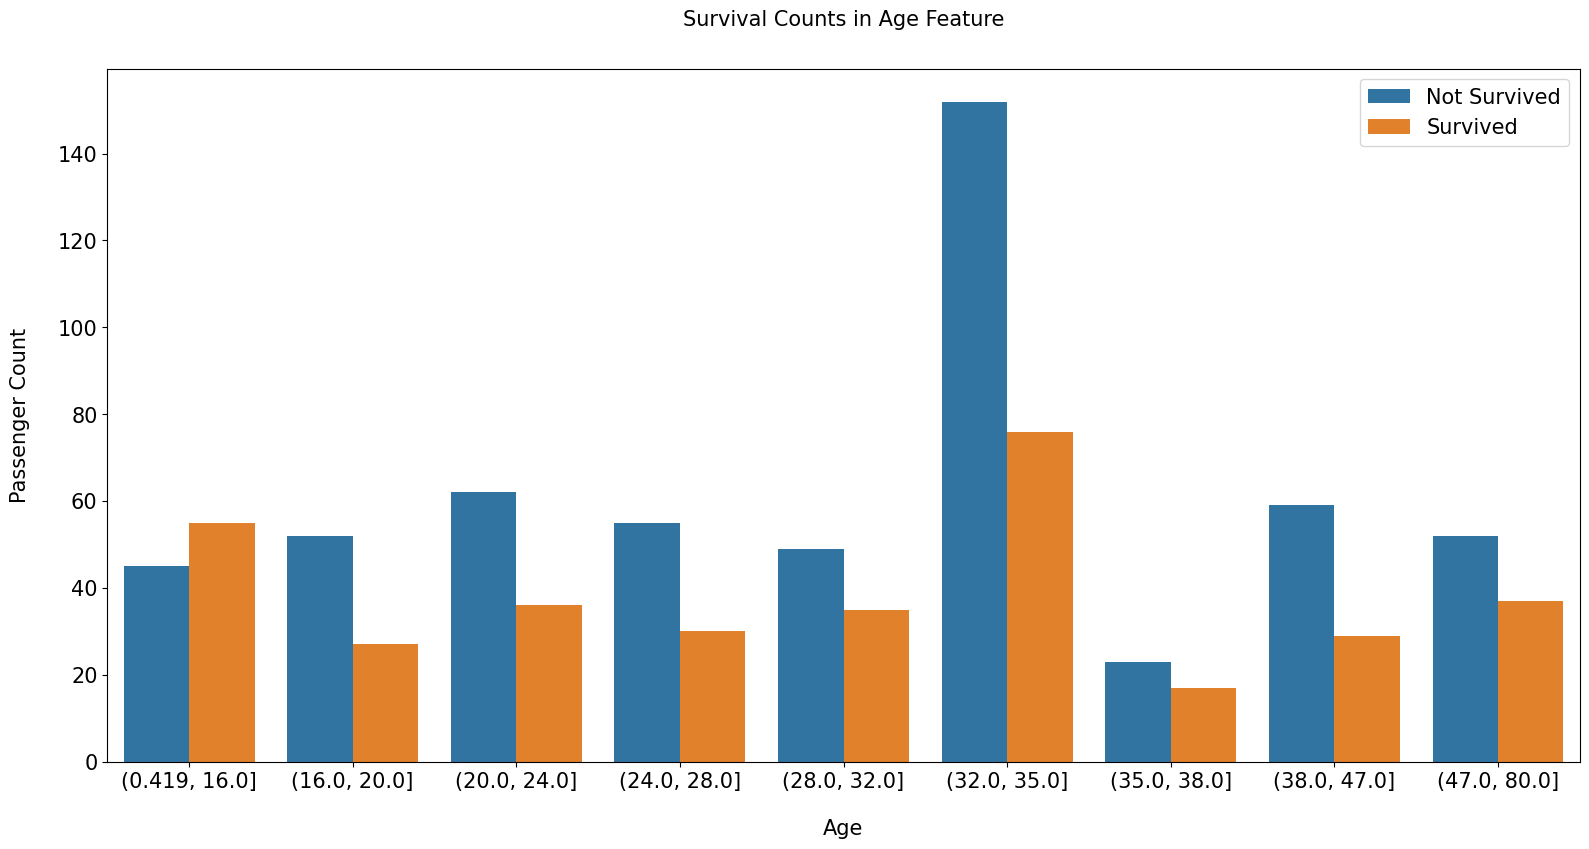

In [38]:
fig, axs = plt.subplots(figsize=(19, 9))
sns.countplot(x='Age', hue='Survived', data=df)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### **2.2 Frequency Encoding**
`Family_Size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

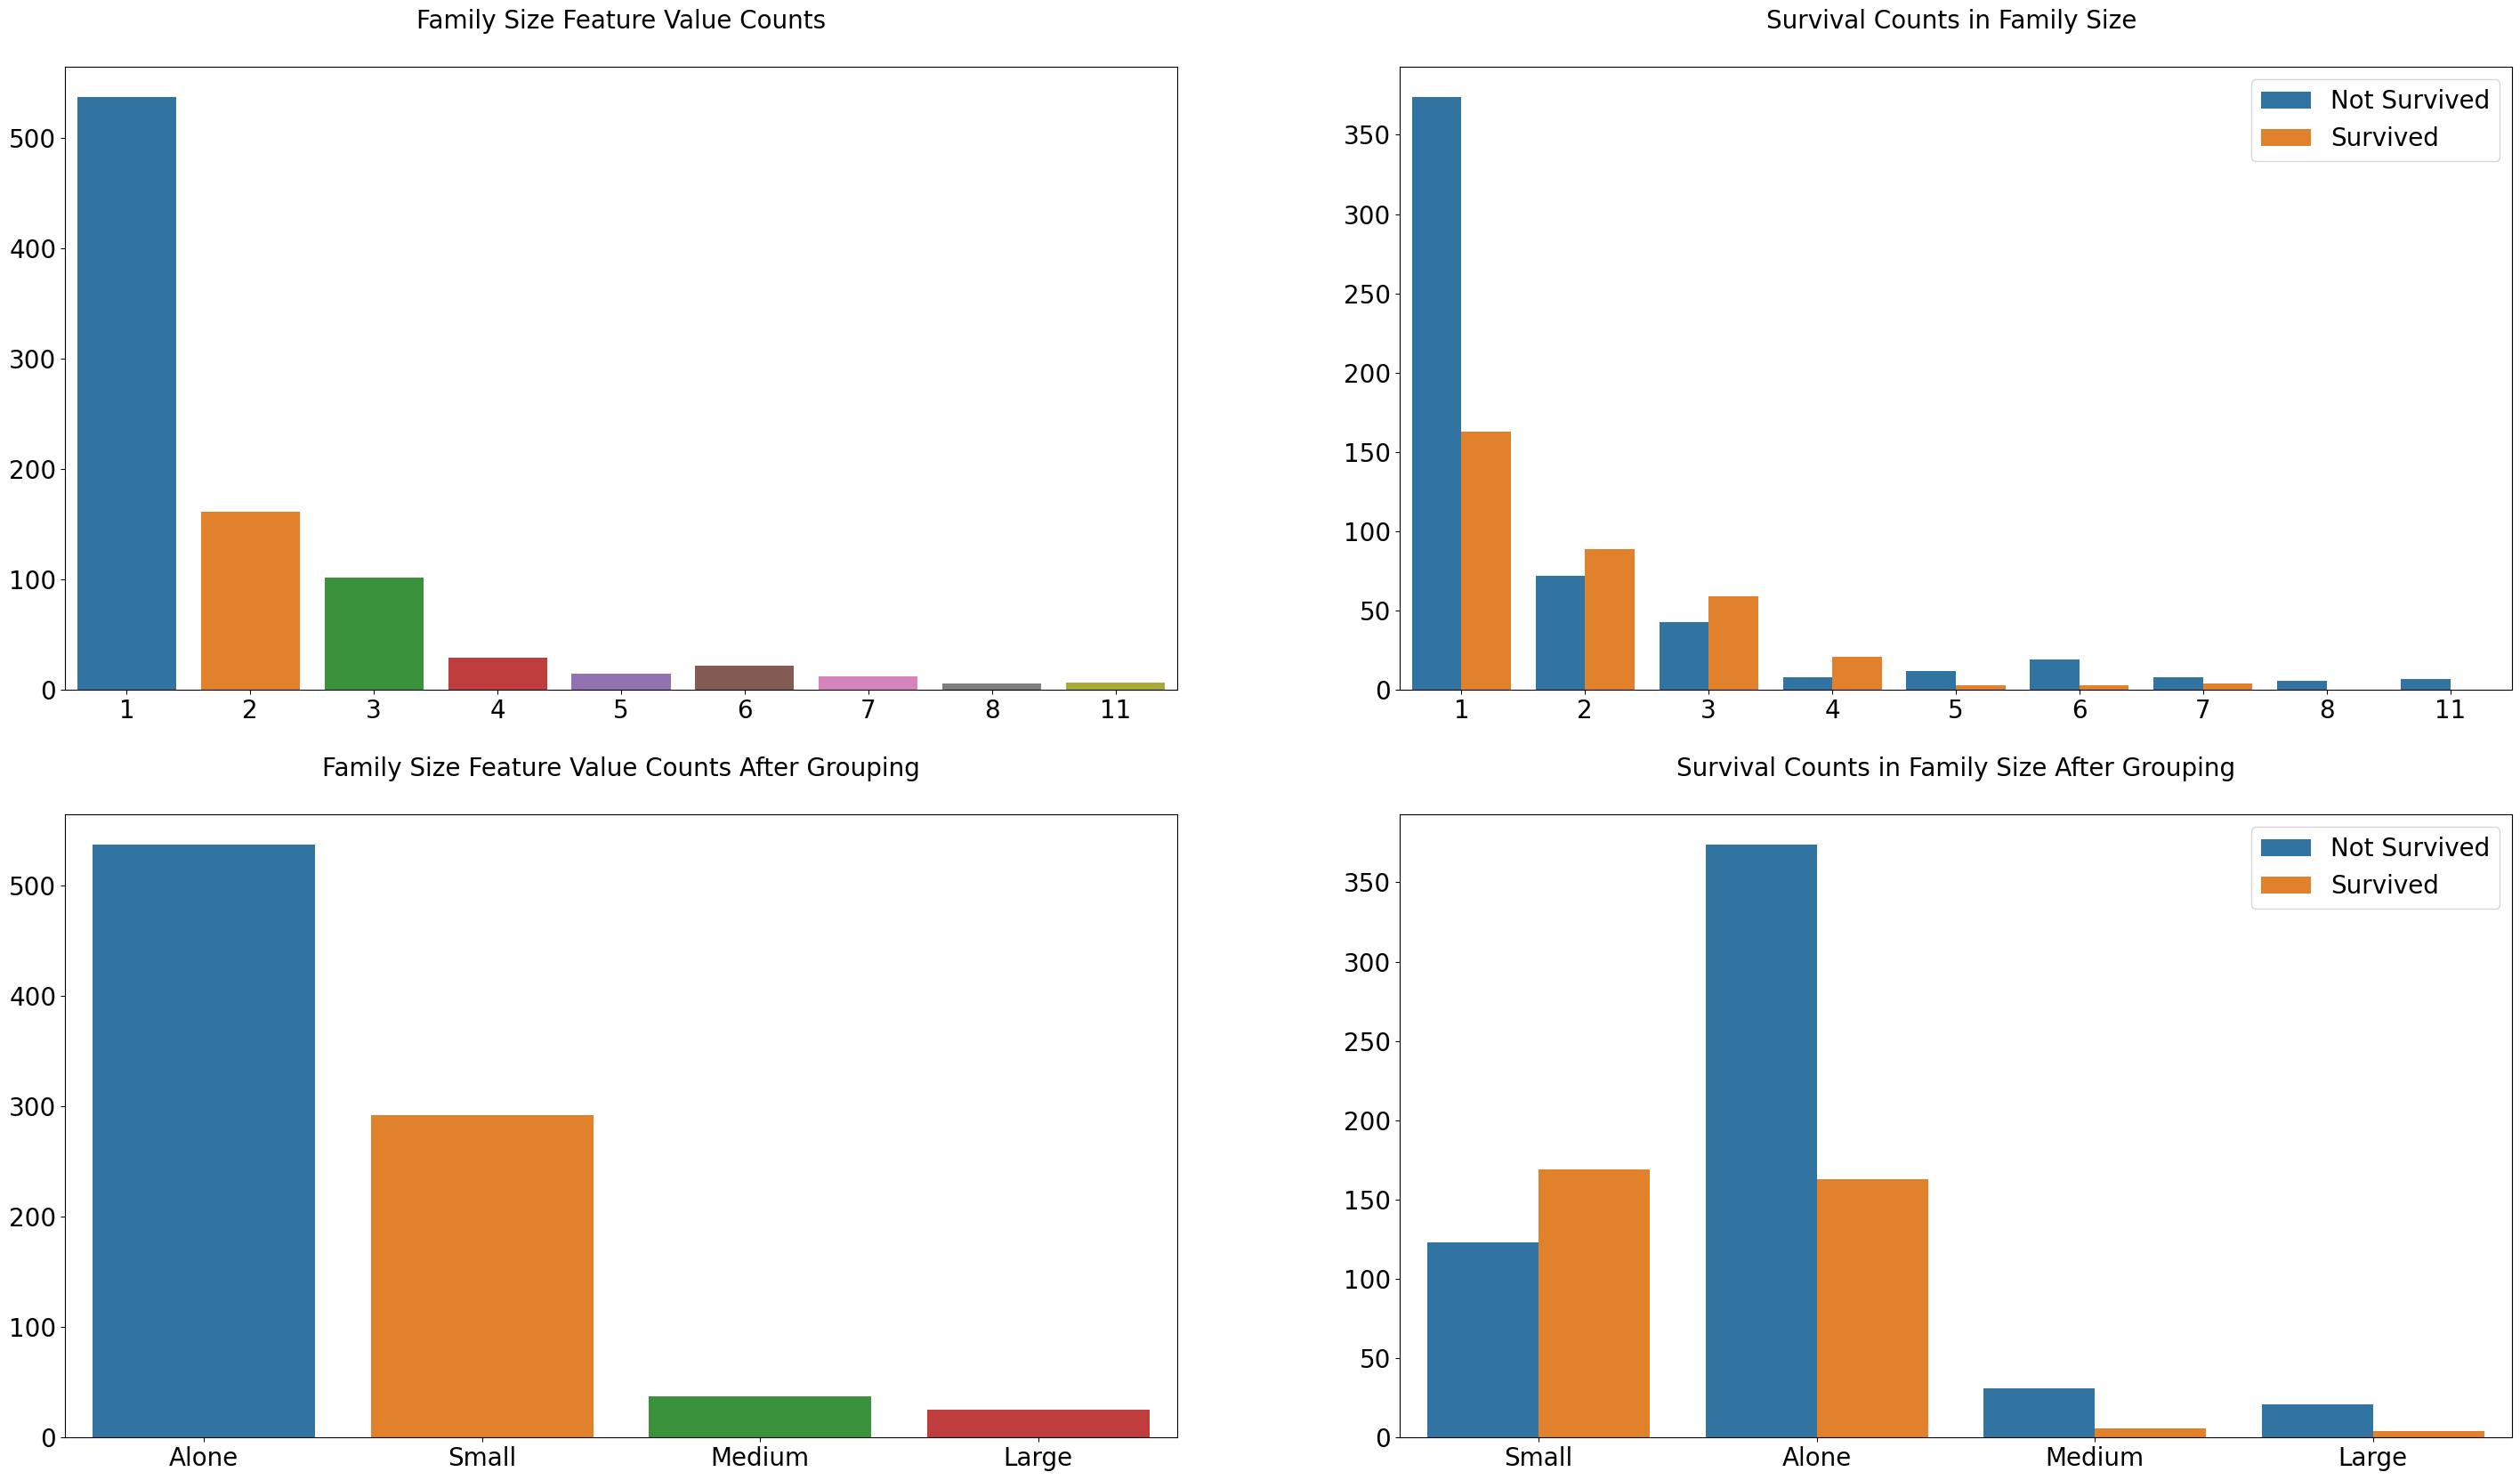

In [39]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df['Family_Size'].value_counts().index, y=df['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df['Family_Size_Grouped'] = df['Family_Size'].map(family_map)

sns.barplot(x=df['Family_Size_Grouped'].value_counts().index, y=df['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

There are too many unique `Ticket` values to analyze, so grouping them up by their frequencies makes things easier.

**How is this feature different than `Family_Size`?** Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

**Why not grouping tickets by their prefixes?** If prefixes in `Ticket` feature has any meaning, then they are already captured in `Pclass` or `Embarked` features because that could be the only logical information which can be derived from the `Ticket` feature.

According to the graph below, groups with **2**,**3** and **4** members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After **4** group members, survival rate decreases drastically. This pattern is very similar to `Family_Size` feature but there are minor differences. `Ticket_Frequency` values are not grouped like `Family_Size` because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [40]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

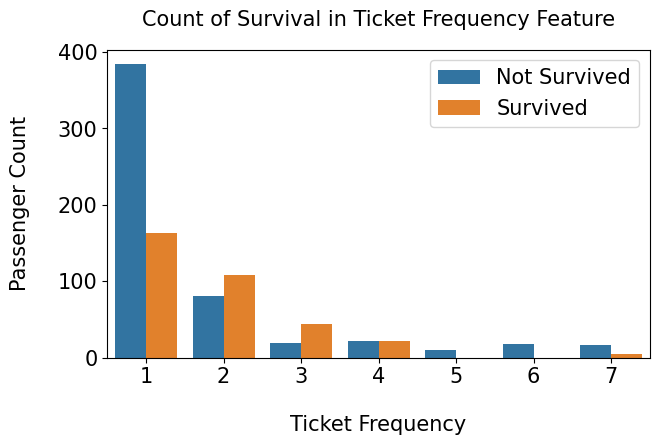

In [41]:
fig, axs = plt.subplots(figsize=(7,4))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### **2.3 Title & Is Married**
`Title` is created by extracting the prefix before `Name` feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are female. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma. **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all males.

`Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [42]:
df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Is_Married'] = 0
df.loc[df['Title'] == 'Mrs', 'Is_Married'] = 1

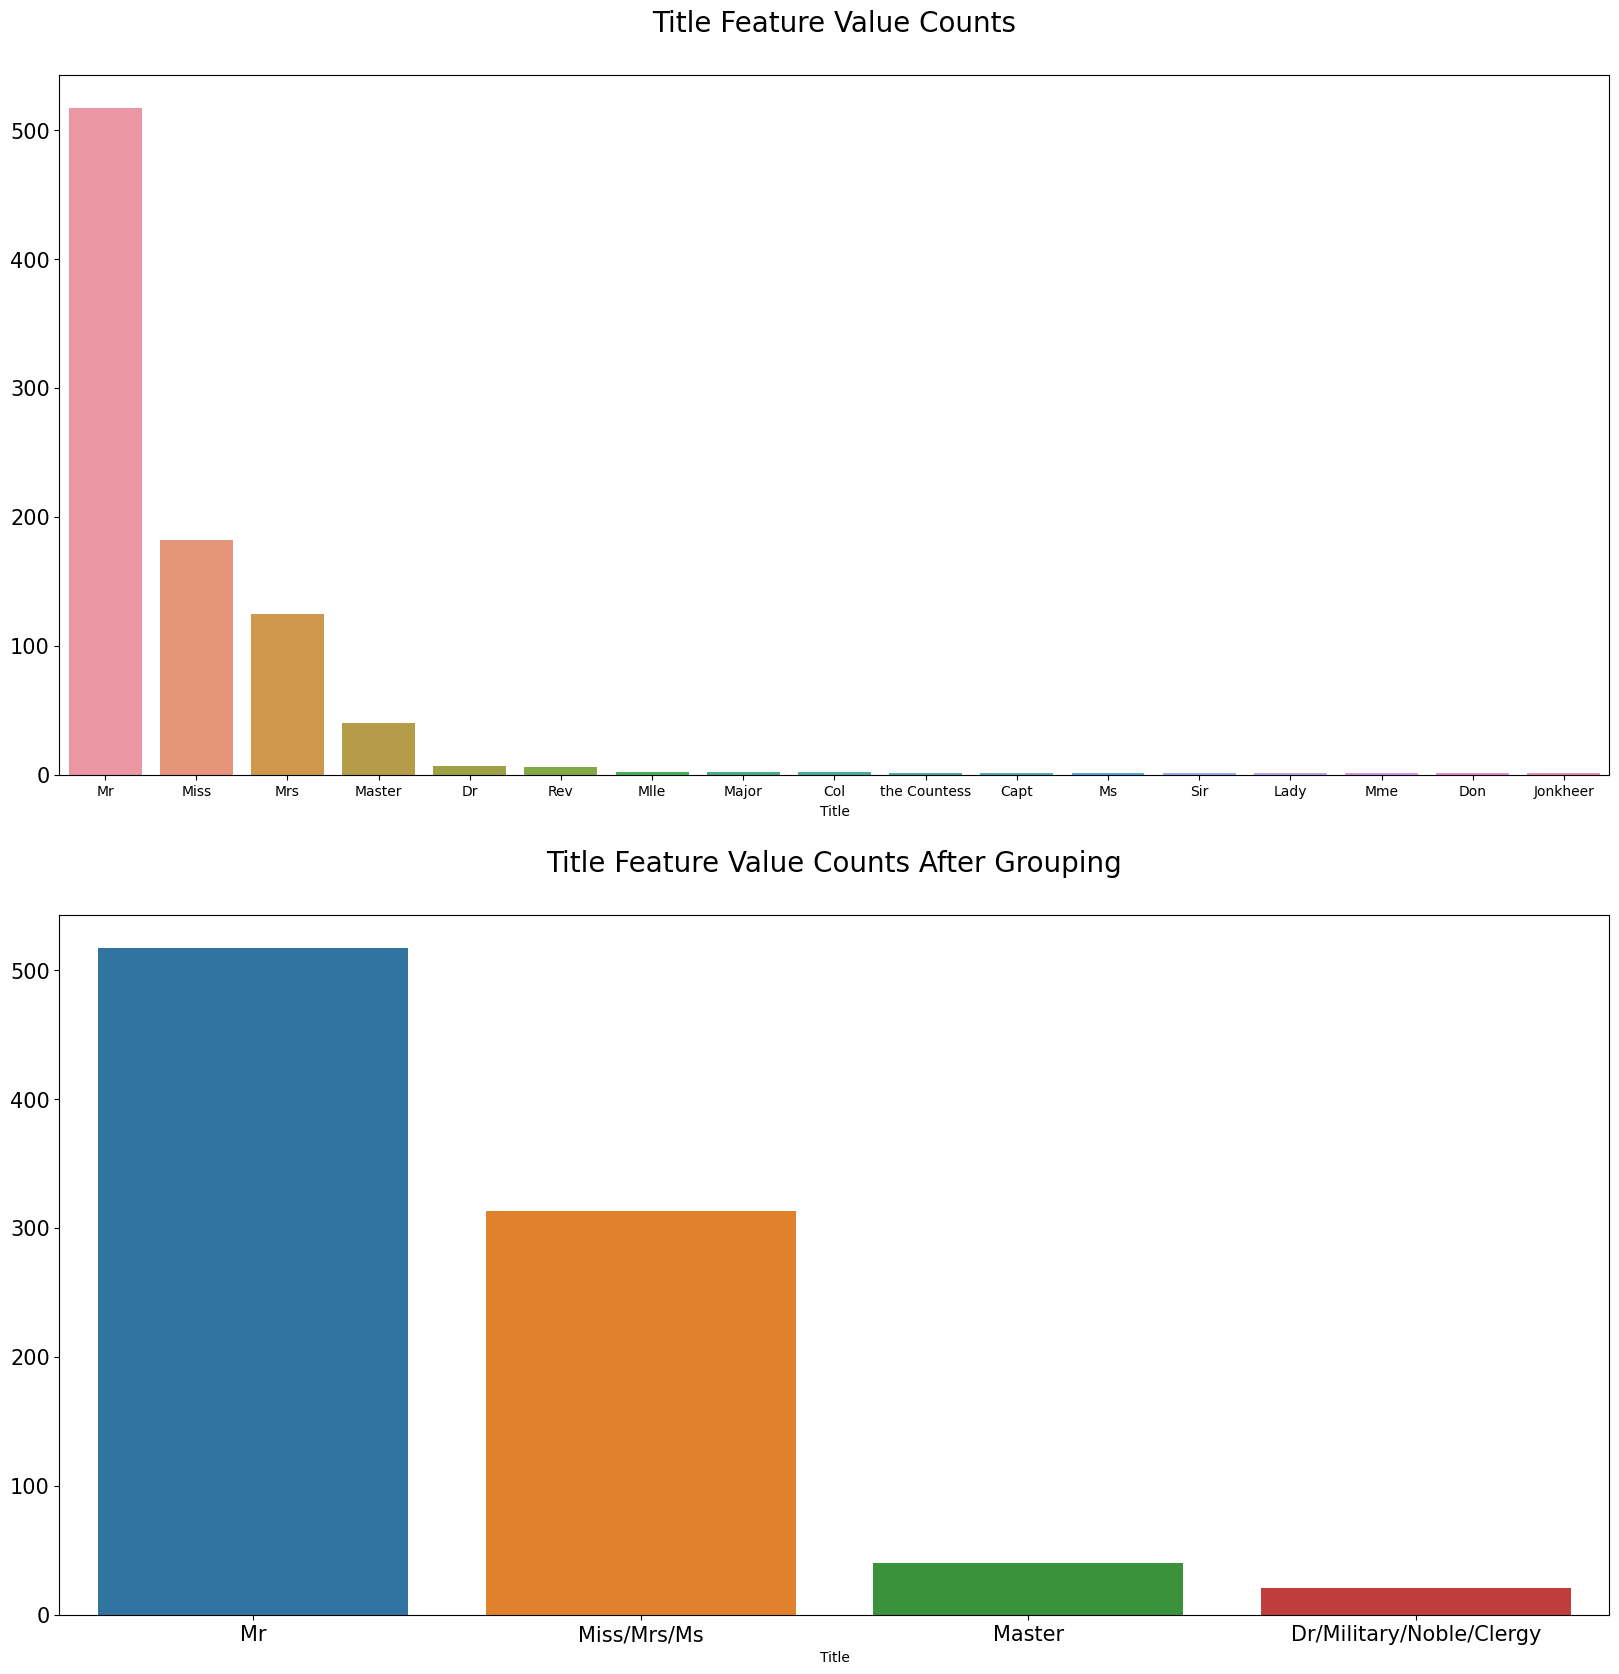

In [43]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df['Title'].value_counts().index, y=df['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df['Title'].value_counts().index, y=df['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

In [44]:
df['Title'].value_counts()

Title
Mr                          517
Miss/Mrs/Ms                 313
Master                       40
Dr/Military/Noble/Clergy     21
Name: count, dtype: int64

### **2.4 Target Encoding**
`extract_surname` function is used for extracting surnames of passengers from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping passengers in the same family. 

In [45]:
df.Name.sample(5)

466                           Campbell, Mr. William
849    Goldenberg, Mrs. Samuel L (Edwiga Grabowska)
445                       Dodge, Master. Washington
73                      Chronopoulos, Mr. Apostolos
599    Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")
Name: Name, dtype: object

In [46]:
import string
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c,'').strip()
            
        families.append(family)
            
    return families

df['Family'] = extract_surname(df['Name'])


`Family_Survival_Rate` is calculated from families in training set since there is no `Survived` feature in test set. A list of family names that are occuring in both training and test set (`non_unique_families`), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in `Family_Survival_Rate` feature.

An extra binary feature `Family_Survival_Rate_NA` is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

`Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are also created with the same method. `Ticket_Survival_Rate` and `Family_Survival_Rate` are averaged and become `Survival_Rate`, and `Ticket_Survival_Rate_NA` and `Family_Survival_Rate_NA` are also averaged and become `Survival_Rate_NA`.

In [47]:
df_family_survival_rate = df[['Survived', 'Family','Family_Size']].groupby('Family').median()
df_family_survival_rate

Survived  Family_Size
Family                              
Abbing              0.0          1.0
Abbott              0.5          3.0
Abelson             0.5          2.0
Adahl               0.0          1.0
Adams               0.0          1.0
...                 ...          ...
de Mulder           1.0          1.0
de Pelsmaeker       0.0          1.0
del Carlo           0.0          2.0
van Billiard        0.0          3.0
van Melkebeke       0.0          1.0

[667 rows x 2 columns]

In [48]:
df_ticket_survival_rate = df[['Survived', 'Ticket','Ticket_Frequency']].groupby('Ticket').median()
df_ticket_survival_rate

Survived  Ticket_Frequency
Ticket                                 
110152            1.0               3.0
110413            1.0               3.0
110465            0.0               2.0
110564            1.0               1.0
110813            1.0               1.0
...               ...               ...
W./C. 6608        0.0               4.0
W./C. 6609        0.0               1.0
W.E.P. 5734       0.0               1.0
W/C 14208         0.0               1.0
WE/P 5735         0.5               2.0

[681 rows x 2 columns]

In [49]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df['Family'].unique() ]
non_unique_tickets = [x for x in df['Ticket'].unique()]

df_family_survival_rate = df[['Survived', 'Family','Family_Size']].groupby('Family').median()
df_ticket_survival_rate = df[['Survived', 'Ticket','Ticket_Frequency']].groupby('Ticket').median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [50]:
mean_survival_rate = np.mean(df['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df)):
    if df['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df)):
    if df['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df['Family_Survival_Rate'] = train_family_survival_rate
df['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df['Family_Survival_Rate'] = test_family_survival_rate
df['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df)):
    if df['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df)):
    if df['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df['Ticket_Survival_Rate'] = train_ticket_survival_rate
df['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df['Ticket_Survival_Rate'] = test_ticket_survival_rate
df['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [51]:
df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2 

### **2.5 Conclusion**
`Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. `Family_Size` is created by adding `Parch` and `SibSp` features and **1**. `Ticket_Frequency` is created by counting the occurence of `Ticket` values.

`Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers. `Ticket_Survival_Rate` is created by target encoding the `Ticket` feature. `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.